# ANL14-A1: LRA benchmark (2D BWR) - MP coupling
This notebook implements a steady and transient neutron diffusion equation on a MP problem based on the ANL14-A1 benchmark, also referred to as [LRA benchmark](https://www.osti.gov/biblio/12030251) using the [FEniCSx library](https://fenicsproject.org).

In [1]:
from dolfinx.io import gmshio
import gmsh
from mpi4py import MPI
from IPython.display import clear_output
from tqdm import tqdm

import numpy as np
import ufl
from dolfinx.fem import (Function, Expression)
from dolfinx.io import XDMFFile

import matplotlib.pyplot as plt
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore")

import sys

mesh_path      = '../../../mesh/'
benchmark_path = '../../../BenchmarkData/'

sys.path.append('../../../models/fenicsx')

## Preamble
The geometry and the main physical parameters will be assigned.

### Mesh Import
The geometry and the mesh are imported from "ANL14-A1.msh", generated with GMSH (the mesh is in cm).

In [2]:
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

mesh_factor = 1.5

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge(mesh_path+'ANL14-A1.geo')
gmsh.model.geo.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")
clear_output()

# Domain
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()
    
regions_markers = [10, 20, 30, 35, 40, 50]
void_marker = 1

boundary_marker = 1

tdim = domain.topology.dim
fdim = tdim - 1

ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
dx = ufl.Measure("dx", domain=domain)

domain.topology.create_connectivity(fdim, tdim)

### Define parameter functions on the different regions
Since there are 5 subdomains in $\Omega$ the values of the parameters changes according to the region, therefore proper functions should be defined.

In [3]:
neutronics_param = dict()

neutronics_param['D'] = [[np.array([1.255, 1.268,  1.259,  1.259,  1.259,  1.257]),  np.array([5e-4] * len(regions_markers))],
                         [np.array([0.211, 0.1902, 0.2091, 0.2091, 0.2091, 0.1592]), np.array([2.5e-3] * len(regions_markers))]]
neutronics_param['xs_a'] = [[np.array([0.008252, 0.007181, 0.008002, 0.008002, 0.008002, 0.0006034]), np.array([7.5e-4] * len(regions_markers))],
                            [np.array([0.1003,   0.07047,  0.08344,  0.08344,  0.073324, 0.01911]),   np.array([1e-3] * len(regions_markers))]]
neutronics_param['nu_xs_f'] = [[np.array([0.004602, 0.004609, 0.004663, 0.004663, 0.004663, 0.]), np.array([0.] * len(regions_markers))],
                               [np.array([0.1091,   0.08675,  0.1021,   0.1021,   0.1021,   0.]), np.array([0.] * len(regions_markers))]]
neutronics_param['xs_f'] = [[np.array([0.001894, 0.001897, 0.001919, 0.001919, 0.001919, 0.]), np.array([0.] * len(regions_markers))],
                            [np.array([0.044897, 0.035700, 0.042016, 0.042016, 0.042016, 0.]), np.array([0.] * len(regions_markers))]]
neutronics_param['xs_s'] = [[np.array([0.] * len(regions_markers)), [np.array([0.02533, 0.02767, 0.02617, 0.02617, 0.02617, 0.04754]), np.array([0.] * len(regions_markers))]],
                            [[np.array([0.] * len(regions_markers)), np.array([0.] * len(regions_markers))], np.array([0.]*len(regions_markers))]]
neutronics_param['B2z'] = [np.array([1e-4] * len(regions_markers)),
                           np.array([1e-4] * len(regions_markers))]

neutronics_param['chi'] = [[np.array([1.] * len(regions_markers)), np.array([0.] * len(regions_markers))],
                           [np.array([0.] * len(regions_markers)), np.array([0.] * len(regions_markers))]]

# Kinetic parameters
neutronics_param['v'] =  [3e7, 3e5] #cm/s
neutronics_param['beta_l'] =  np.array([ [0.0054,   0.0054,   0.0054,   0.0054,   0.0054,   0.],
                                         [0.001087, 0.001087, 0.001087, 0.001087, 0.001087, 0.]])
neutronics_param['lambda_p_l'] =  np.array([ [0.0654, 0.0654, 0.0654, 0.0654, 0.0654, 0.],
                                             [1.35,   1.35,   1.35,   1.35,   1.35,   0.]]) # 1/s

neutronics_param['Energy Groups'] = 2
neutronics_param['Tref'] = 600

nu_value = 2.43
Ef = 200e6 * 1.6e-19
reactor_power = 6000

# Thermal parameters
thermal_param = dict()

thermal_param['th_cond'] = np.array([5, 0.5, 2, 0.5, 0.1, 10] * len(regions_markers))
thermal_param['rho_cp'] = np.array([1/1.1954]*len(regions_markers)) / 2500 # must be in J / cm3 - K: value taken from Brega et al., 1981
thermal_param['Energy Groups'] = neutronics_param['Energy Groups']
thermal_param['Tref'] = neutronics_param['Tref']
thermal_param['Ef'] = Ef
thermal_param['k_eff'] = 1.
thermal_param['xs_f'] = neutronics_param['xs_f']

## Steady state solution
The MG diffusion equation is discretised using the Finite Element Method, and its eigenvalue formulation is solved through the standard inverse-power method.

In [4]:
from neutronics.neutr_diff import steady_neutron_diff
from neutronics.thermal import steady_thermal_diffusion

neutr_steady_problem = steady_neutron_diff(domain, ct, ft, neutronics_param, regions_markers, void_marker, coupling='log')
neutr_steady_problem.assembleForm(direct=False)

therm_steady_problem = steady_thermal_diffusion(domain, ct, ft, thermal_param, regions_markers, void_marker, 
                                                TD = 300, coupling='log')
therm_steady_problem.assembleForm(direct=False)

Let us solve the steady problem based on the Picard iteration.

In [5]:
from backends import norms

norm = norms(therm_steady_problem.V)

error = 1.
ii = 0
tol = 1e-4
maxIter = 20

Tguess = Function(therm_steady_problem.V)
Tguess.x.set(neutronics_param['Tref'])

q3_guess = Function(therm_steady_problem.V)

error_fun_T = Function(therm_steady_problem.V).copy()
error_fun_q3 = Function(therm_steady_problem.V).copy()

while error > tol and ii < maxIter:
    
    # Solve neutron diffusion
    phi_ss, k_eff = neutr_steady_problem.solve(temperature=Tguess, power = reactor_power, nu = nu_value, Ef = Ef,  
                                               LL = 50, verbose=False, maxIter = 1000)
    # Solve thermal diffusion
    T_ss = therm_steady_problem.solve(phi_ss, k_eff, temperature=Tguess)
    
    # Compute error
    error_fun_T.x.array[:] = T_ss.x.array[:] - Tguess.x.array[:]
    error_T = norm.L2norm(error_fun_T) / norm.L2norm(Tguess)

    error_fun_q3.interpolate(Expression(therm_steady_problem.q3 - q3_guess, therm_steady_problem.V.element.interpolation_points()))
    
    if max(q3_guess.x.array) > 1e-10:
        error_q3 = norm.L2norm(error_fun_q3) / norm.L2norm(q3_guess)
    else:
        error_q3 = 0.
        k_eff_uncoupled = k_eff

    error = error_q3 + error_T
    print('Iter #'+str(ii))
    print(f'    Error_T: {error_T :.3e} | error_q3: {error_q3 :.3e} | error: {error :.3e}')

    # Update temperature
    Tguess.x.array[:] = T_ss.x.array[:]
    q3_guess.interpolate(Expression(therm_steady_problem.q3, therm_steady_problem.V.element.interpolation_points()))

    ii += 1

    if error <= tol:
        print('--------')
        print('Converged in '+str(ii)+' iterations, k_eff = {:.6f}'.format(k_eff))
        print('--------')
    if ii > maxIter:
        print('--------')
        print('Warning: maximum iterations limit reached !!!')
        print('--------')

Iter #0
    Error_T: 4.091e-01 | error_q3: 0.000e+00 | error: 4.091e-01
Iter #1
    Error_T: 2.612e-02 | error_q3: 8.600e-02 | error: 1.121e-01
Iter #2
    Error_T: 3.702e-03 | error_q3: 1.754e-02 | error: 2.125e-02
Iter #3
    Error_T: 7.918e-04 | error_q3: 4.280e-03 | error: 5.071e-03
Iter #4
    Error_T: 1.848e-04 | error_q3: 1.032e-03 | error: 1.217e-03
Iter #5
    Error_T: 4.408e-05 | error_q3: 2.519e-04 | error: 2.959e-04
Iter #6
    Error_T: 1.066e-05 | error_q3: 6.262e-05 | error: 7.328e-05
--------
Converged in 7 iterations, k_eff = 0.990841
--------


Let us compare the multiplication factors

In [6]:
print('k_eff uncoupled {:.6f}'.format(k_eff_uncoupled))
print('k_eff   coupled {:.6f}'.format(k_eff))
print('Reactivity Difference {:.3f}'.format(np.abs(k_eff - k_eff_uncoupled) / k_eff_uncoupled * 1e5)+ ' (pcm)')

k_eff uncoupled 0.996424
k_eff   coupled 0.990841
Reactivity Difference 560.318 (pcm)


### Post-processing
The solution of the steady problem is plotted using pyvista.

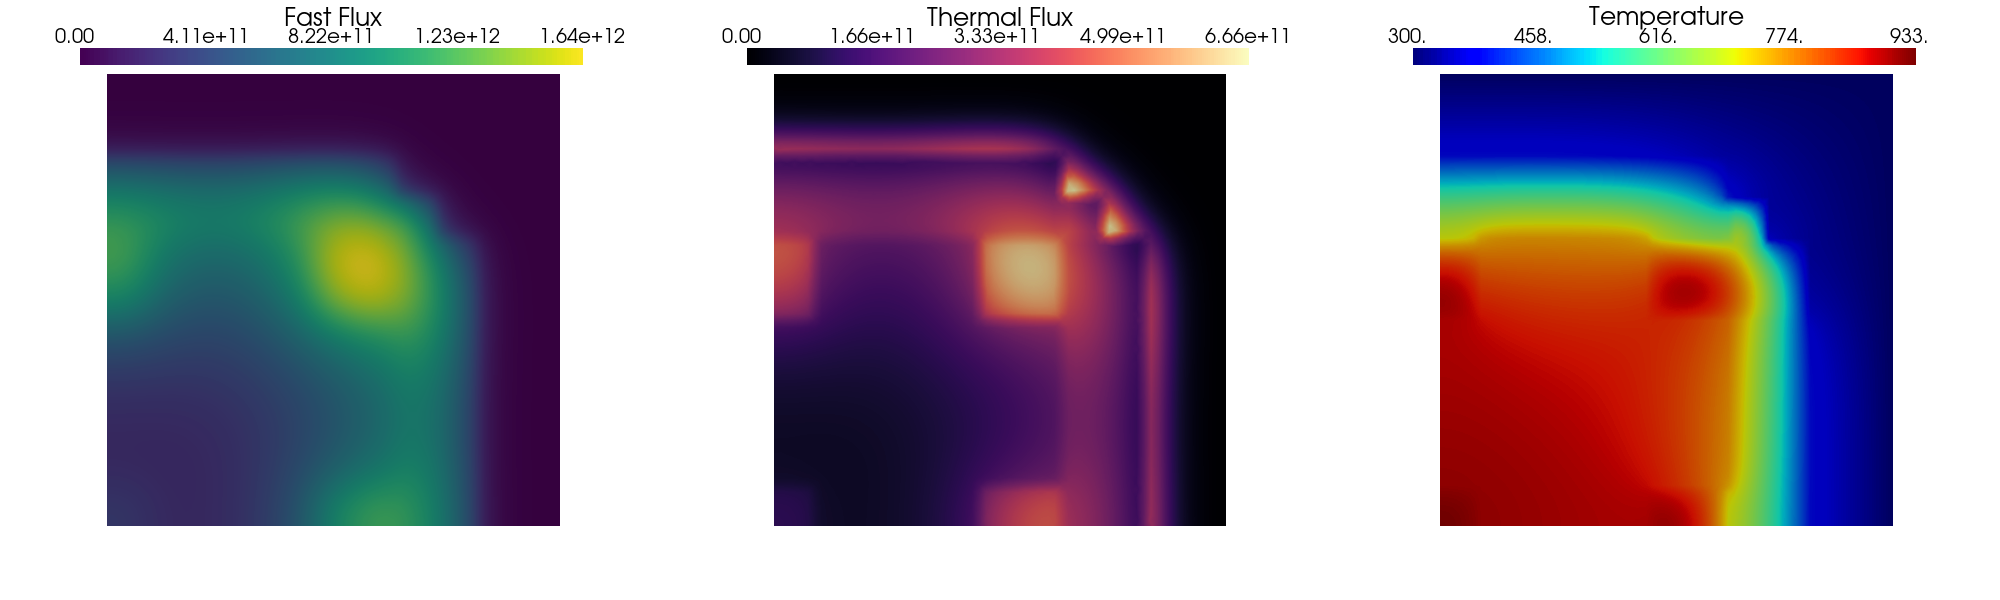

In [7]:
import pyvista as pv
from plotting import get_scalar_grid

def subPlot_flux(fast: Function, thermal: Function, temperature: Function, time = None,
                 filename: str = None, clim = [None]*3, 
                 cmap = [cm.viridis, cm.magma, cm.jet], resolution = [2000, 600]):

    plotter = pv.Plotter(shape=(1,3), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 25
    zoom = 1.1
    
    dict_cb = dict(title = ' ', width = 0.76,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    color='k',
                    position_x=0.12, position_y=0.89,
                    shadow=True) 

    clim_scale = .01
    
    ################### Fast Flux ###################
    plotter.subplot(0,0)
    if clim[0] is None:    
        clim1 = [0,  max(fast.x.array) * (1+clim_scale)]
    else:
        clim1 = clim[0]
    dict_cb['title'] = 'Fast Flux'
    plotter.add_mesh(get_scalar_grid(fast, varname='phi1'), cmap = cmap[0], clim = clim1, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    ################### Thermal Flux ###################
    plotter.subplot(0,1)
    if clim[1] is None:
        clim2 = [0,  max(thermal.x.array) * (1+clim_scale)]
    else:
        clim2 = clim[1]
    dict_cb['title'] = 'Thermal Flux'
    plotter.add_mesh(get_scalar_grid(thermal, varname='phi2'), cmap = cmap[1], clim = clim2, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    ################### Thermal Flux ###################
    plotter.subplot(0,2)
    if clim[2] is None:
        clim3 = [min(temperature.x.array),  max(temperature.x.array) * (1+clim_scale)]
    else:
        clim3 = clim[1]
    dict_cb['title'] = 'Temperature'
    plotter.add_mesh(get_scalar_grid(temperature, varname='temperature'), cmap = cmap[2], clim = clim3, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    if time is not None:
        plotter.add_text(r'Time = {:.3f}'.format(time)+' s', color= 'k', position=[200, 0], font_size=30)
    
    ###### Save figure ######
    plotter.set_background('white', top='white')
    
    if filename is not None:
        plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
    else:
        plotter.show()
        
# pv.start_xvfb()
subPlot_flux(phi_ss[0], phi_ss[1], T_ss, filename=None)

## Transient
Now let us assess the capabilities of the solver in solving transient problems.

In [8]:
from neutronics.neutr_diff import transient_neutron_diff
from neutronics.thermal import transient_thermal_diffusion

neutronics_param['k_eff_0'] = k_eff
thermal_param['k_eff'] = k_eff
neutronics_param['nu_xs_f'] = [[np.array([0.004602, 0.004609, 0.004663, 0.004663, 0.004663, 0.]) / k_eff, np.array([0.] * len(regions_markers))],
                               [np.array([0.1091,   0.08675,  0.1021,   0.1021,   0.1021,   0.]) / k_eff, np.array([0.] * len(regions_markers))]]

neutr_trans_problem = transient_neutron_diff(domain, ct, ft, neutronics_param, regions_markers, boundary_marker, 
                                             coupling = 'log')
therm_trans_problem = transient_thermal_diffusion(domain, ct, ft, thermal_param, regions_markers, void_marker, 
                                                  TD = 300, coupling='log')

Let us create the structures to save the data of the transient simulations.

In [9]:
QoI_over_time = dict()
QoI_over_time['Power'] = list()
QoI_over_time['Ave_T'] = list()

The absorption cross section in region 4 is decreased according to the following law

$$
\Sigma_{a,2}(\mathbf{x},t) = \Sigma_{a,2}^{0}(\mathbf{x})\cdot \left[ \mathcal{H}(0.2-t)\cdot (1-0.1\,t) + \mathcal{H}(t-0.2)\cdot 0.98 \right]
$$

given $\mathbf{x}\in\Omega_4$ and $\mathcal{H}(t)$ the Heaviside step function.

The absorption cross section in region 4 is decreased according to the following law

$$
\Sigma_{a,2}(\mathbf{x},t) = \Sigma_{a,2}^{0}(\mathbf{x})\cdot \mathcal{H}(t)\cdot\left[ 0.98 + 0.01 \cdot \cos\left(8\pi\,\frac{t}{t^\star}\right) \cdot e^{-\frac{t^2}{0.2}} \right]
$$

given $\mathbf{x}\in\Omega_4$ and $\mathcal{H}(t)$ the Heaviside step function.

In [10]:
t_star = 1.

step = lambda t: np.piecewise(t, 
                             [t <= 0, t > 0],
                             [lambda x: 1 + 0.0 * x, lambda x: 0.96 + 0.0 * x])
ramp = lambda t: np.piecewise(t, 
                             [t <= 0, ((t > 0.) & (t < 0.2)), t >= 0.2],
                             [lambda x: 1 + 0.0 * x, lambda x: 1 - 0.2 * x, lambda x: 0.0 * x + 0.96])
exp_sine = lambda t: np.heaviside(t, 1.) * (-0.01 * np.sin(t / t_star * 4 * 2*np.pi) * (np.exp(-t**2/0.2))+0.98)

dt = 1e-3
neutr_trans_problem.assembleForm(phi_ss, dt, nu = nu_value, Ef = Ef, direct=False)
therm_trans_problem.assembleForm(T_ss, dt, direct = False)

T = 1.5

Let us plot the reactivity insertion

(0.95, 1.0)

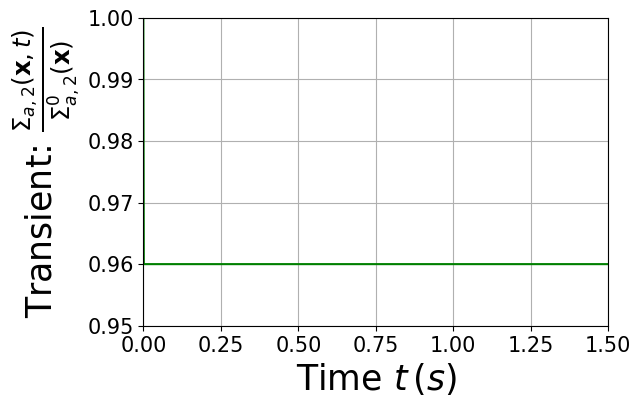

In [11]:
t = np.linspace(-1e-15, T, 1000)
fig = plt.figure(figsize=(6,4))

# plt.plot(t, exp_sine(t), 'r')
# plt.plot(t, ramp(t), 'b')
plt.plot(t, step(t), 'g')
plt.xlim(0,max(t))
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel(r"Time $t\,(s)$",fontsize=25)
plt.ylabel(r"Transient: $\frac{\Sigma_{a,2}(\mathbf{x},t)}{\Sigma_{a,2}^0(\mathbf{x})}$",fontsize=25)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.yticks(np.arange(0.95, 1.005, 0.01))
plt.ylim(0.95, 1.)

Let us prepare to save the snapshots

In [12]:
store_snaps = False

if store_snaps:

    fast_xdmf    = XDMFFile(domain.comm, "ANL14A1_MP/fast_flux.xdmf", "w")
    thermal_xdmf = XDMFFile(domain.comm, "ANL14A1_MP/thermal_flux.xdmf", "w")
    temperature_xdmf = XDMFFile(domain.comm, "ANL14A1_MP/temperature.xdmf", "w")

    fast_xdmf.write_mesh(domain)
    thermal_xdmf.write_mesh(domain)
    temperature_xdmf.write_mesh(domain)

Let us solve this transient

In [13]:
xs_a1_transient = lambda t: np.array([neutronics_param['xs_a'][0][0][ii] for ii in range(len(regions_markers))])

xs_a2_transient = lambda t: np.array([neutronics_param['xs_a'][1][0][0], 
                                      neutronics_param['xs_a'][1][0][1],
                                      neutronics_param['xs_a'][1][0][2],
                                      # neutronics_param['xs_a'][1][0][3] * exp_sine(t),
                                      # neutronics_param['xs_a'][1][0][3] * ramp(t),
                                      neutronics_param['xs_a'][1][0][3] * step(t),
                                      neutronics_param['xs_a'][1][0][4],
                                      neutronics_param['xs_a'][1][0][5]])

xs_a_transient = [xs_a1_transient, xs_a2_transient]

t = 0.
num_steps = int(T / dt)  

QoI_over_time['Power'].append( np.array([0., reactor_power]) )
QoI_over_time['Ave_T'].append( np.array([0., np.mean(T_ss.x.array[:])]) )

prog_bar_ramp = tqdm(desc="Ramp Transient", total=num_steps)

while t < T:
    t += dt
    
    power, phi_t = neutr_trans_problem.advance(t, xs_a_transient, therm_trans_problem.T_old)
    T_t = therm_trans_problem.advance(phi_t)
    
    QoI_over_time['Power'].append( np.array([t, power]) )
    QoI_over_time['Ave_T'].append( np.array([t, np.mean(T_t.x.array[:])]) )
    
    
    if store_snaps:
        phi_t[0].name = 'phi1'
        phi_t[1].name = 'phi2'
        T_t.name      = 'T'
        
        fast_xdmf.write_function(phi_t[0], t)
        thermal_xdmf.write_function(phi_t[1], t)
        temperature_xdmf.write_function(T_t, t)
    
    prog_bar_ramp.update(1)
        
QoI_over_time['Power'] = np.asarray(QoI_over_time['Power'])
QoI_over_time['Ave_T'] = np.asarray(QoI_over_time['Ave_T'])

if store_snaps:
    fast_xdmf.close()
    thermal_xdmf.close()
    temperature_xdmf.close()

Ramp Transient:   0%|          | 0/1500 [00:00<?, ?it/s]

Ramp Transient: 1501it [04:15,  6.48it/s]                          

### Post-processing
The solution of the steady problem is plotted using pyvista.

Text(0, 0.5, 'Temperature Difference $\\langle\\delta T\\rangle\\,(\\text{K})$')

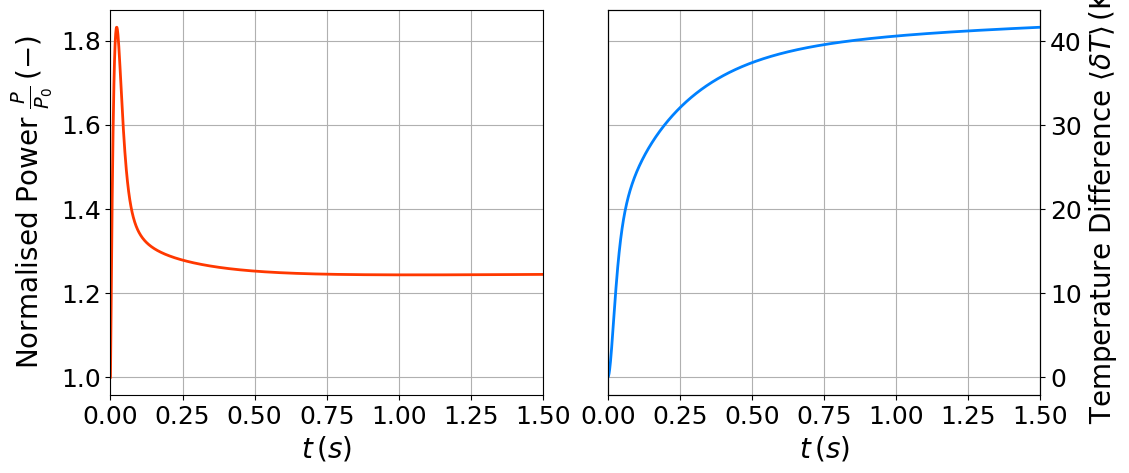

In [14]:
mark_size = 7
ls = 2
labelsize = 20
tickssize = 18
legend_size = 18


fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1, 2, hspace=0.0, wspace=0.15)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(QoI_over_time['Power'][:, 0], QoI_over_time['Power'][:, 1] / reactor_power, '-', color=cm.jet(0.85), linewidth=ls, label = r'dolfinx')
axs[0].set_xlabel(r"$t\,(s)$",fontsize=labelsize)
axs[0].set_ylabel(r"Normalised Power $\frac{P}{P_0}\,(-)$",fontsize=labelsize)
axs[0].set_xlim(0,T)
axs[0].set_xticks(np.arange(0.0, T+0.01, 0.25))
axs[0].tick_params(axis='x', labelsize=tickssize)
axs[0].tick_params(axis='y', labelsize=tickssize)
axs[0].grid(which='major',linestyle='-')
axs[0].grid(which='minor',linestyle='--')

ax_ = axs[1].twinx()
axs[1].set_yticks([])
ax_.plot(QoI_over_time['Ave_T'][:, 0], QoI_over_time['Ave_T'][:, 1] - np.mean(T_ss.x.array), '-', color=cm.jet(0.25), linewidth=ls, label = r'dolfinx')
axs[1].set_xlabel(r"$t\,(s)$",fontsize=labelsize)
axs[1].set_xlim(0,T)
axs[1].set_xticks(np.arange(0.0, T+0.01, 0.25))
axs[1].tick_params(axis='x', labelsize=tickssize)
ax_.tick_params(axis='y', labelsize=tickssize)
ax_.grid(which='major',linestyle='-')
ax_.grid(which='minor',linestyle='--')
axs[1].grid(which='major',linestyle='-')
axs[1].grid(which='minor',linestyle='--')
ax_.set_ylabel(r"Temperature Difference $\langle\delta T\rangle\,(\text{K})$",fontsize=labelsize)

Let us make a contour plot

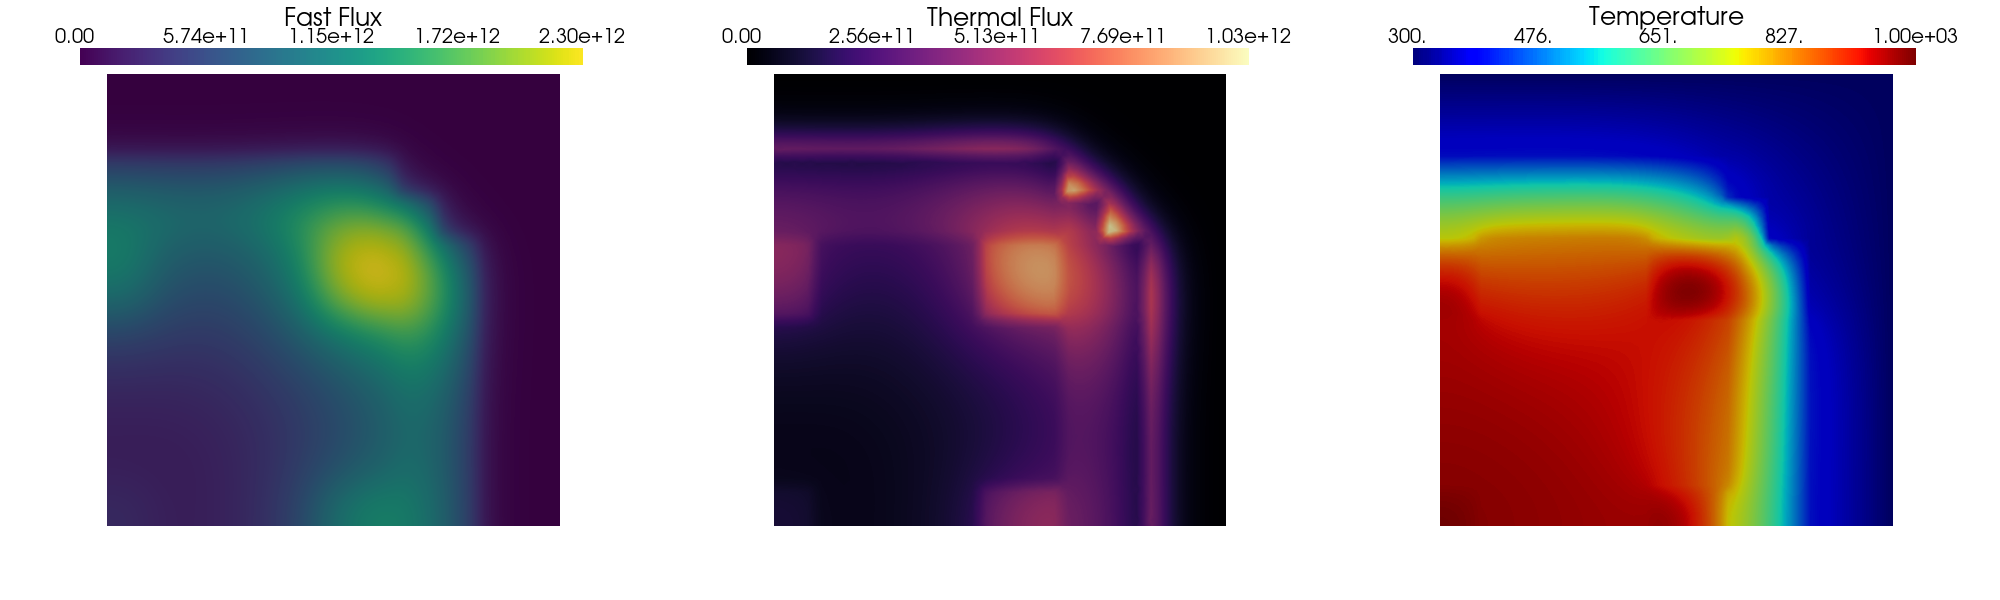

In [15]:
# pv.start_xvfb()
subPlot_flux(phi_t[0], phi_t[1], T_t, filename=None)